# Network training

For our project, we constructed a Vision Transformer (ViT) instance that we named `GlowDeTR` to assess how light exposure affects Neural Network's result at classification.

In [ ]:
import torch
import json
import ast
import torch.nn as nn
import numpy as np
import albumentations
from math import floor
from tqdm import tqdm

from pathlib import Path
from PIL import Image, ImageDraw
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, AutoModelForObjectDetection, AutoImageProcessor, TrainingArguments, Trainer, YolosForObjectDetection
from datasets import load_dataset, Dataset
from tenacity import retry, wait_fixed, stop_after_attempt

# huggingface-cli download yin30lei/day_and_night_traffic_lights --repo-type dataset --local-dir ./traffic_lights

In [ ]:
@retry(wait=wait_fixed(5), stop=stop_after_attempt(5))
def load_with_retry():
    return load_dataset("yin30lei/wildlife-from-wildme", split="train[:20%]", cache_dir=Path.cwd() / "wildlife", num_proc=2)

wildlife_ds = load_with_retry()

Resolving data files:   0%|          | 0/5292 [00:00<?, ?it/s]

In [3]:
class GlowDeTR(nn.Module):
    def __init__(self, pretrained_name="SenseTime/deformable-detr", ignore_mismatch_sz=True, id2label=None, label2id=None):
        super(GlowDeTR, self).__init__()
        # Load pretrained ViT backbone
        self.detr = AutoModelForObjectDetection.from_pretrained(
            pretrained_name,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True)

    def forward(self, pixel_values):        
        return self.detr(pixel_values)
    
tensor2PIL = transforms.ToPILImage()

transform1 = albumentations.Compose(
    [
        # albumentations.HorizontalFlip(p=1.0),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.LongestMaxSize(max_size=600),
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
device = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
wildlife_ds

Dataset({
    features: ['image', 'bbox', 'category', 'label'],
    num_rows: 2116
})

In [5]:
wildlife_ds[10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2400x1611>,
 'bbox': '[[74.58563535911603, 235.35911602209944, 1366.5745856353592, 1375.6906077348067]]',
 'category': 0,
 'label': 'leopard'}

In [6]:
# Two labels: leopard & hyenas
try:
    print(wildlife_ds["train"])
    print("And the first entry")
    wildlife_ds["train"][0]
    wildlife_train_ds = wildlife_ds["train"]
    # wildlife_train_ds = format_ds_dict(wildlife_train_ds)
except Exception as e:
    print(f"Errored due to -> {e}")
    wildlife_train_ds = wildlife_ds
    del wildlife_ds

Errored due to -> "Column train not in the dataset. Current columns in the dataset: ['image', 'bbox', 'category', 'label']"


In [7]:

def update_record(record, idx):
    width, height = record["image"].size  # Assuming "image" is a PIL Image
    record["image_id"] = idx
    record["width"] = width
    record["height"] = height

    # Parse and update "bbox"
    box = record["bbox"]
    record["objects"] = {}
    record["objects"]["label"] = record["label"]
    bbox_list = ast.literal_eval(box)
    record["objects"]["bbox"] = []
    for ent in bbox_list:
        x1, y1, x2, y2 = ent
        
        x1 /= width
        y1 /= height
        x2 /= width
        y2 /= height

        # Clamp values to ensure within [0, 1]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(1, x2), min(1, y2)

        # Append the normalized and clamped bbox
        record["objects"]["bbox"].append([x1, y1, x2, y2])
    
    record["objects"]["area"] = []
    for entry in bbox_list:
        w = entry[2]
        h = entry[3]
        record["objects"]["area"].append(abs(w) * abs(h))
    
    record["objects"]["category"] = [record["category"] for _ in range(len(bbox_list))]
    
    record.pop("category", None)
    record.pop("bbox", None)
    record.pop("label", None)
    return record

# # Use the map function to apply the update
wildlife_train_ds = wildlife_train_ds.map(
    lambda record, idx: update_record(record, idx),
    with_indices=True,
)

# new_data = []
# for idx, record in enumerate(tqdm(wildlife_train_ds)):
#     updated_record = update_record(record, idx)
#     new_data.append(updated_record)
#     if idx == 100:
#         break

# # Convert list of dictionaries to a dictionary of lists
# data_dict = {key: [item[key] for item in new_data] for key in new_data[0].keys()}

# # Create Dataset from dictionary
# wildlife_train_ds = Dataset.from_dict(data_dict)

#! So in this dataset, there might be multiple bbox but only 1 type, for a given entry
print(f"type(wildlife_train_ds) -> {type(wildlife_train_ds)}")
print()
wildlife_train_ds[10]

type(wildlife_train_ds) -> <class 'datasets.arrow_dataset.Dataset'>



{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2400x1611>,
 'image_id': 10,
 'width': 2400,
 'height': 1611,
 'objects': {'area': [1879983.822227649],
  'bbox': [[0.031077348066298343,
    0.1460950440857228,
    0.5694060773480664,
    0.8539358210644362]],
  'category': [0],
  'label': 'leopard'}}

In [8]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["bbox"])):
        box = annotations["bbox"][i]
        class_idx = annotations["label"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        print(f"height -> {height} | width -> {width}")
        print(f"x1 -> {x1} | y1 -> {y1} | x2 -> {x2} | y2 -> {y2}")
        draw.rectangle((x1, y1, x2, y2), outline="red", width=6)
        draw.text((x1, y1), annotations["label"], fill="white", font_size=40)
    return image

height -> 1611 | width -> 2400
x1 -> 74 | y1 -> 235 | x2 -> 1441 | y2 -> 1611


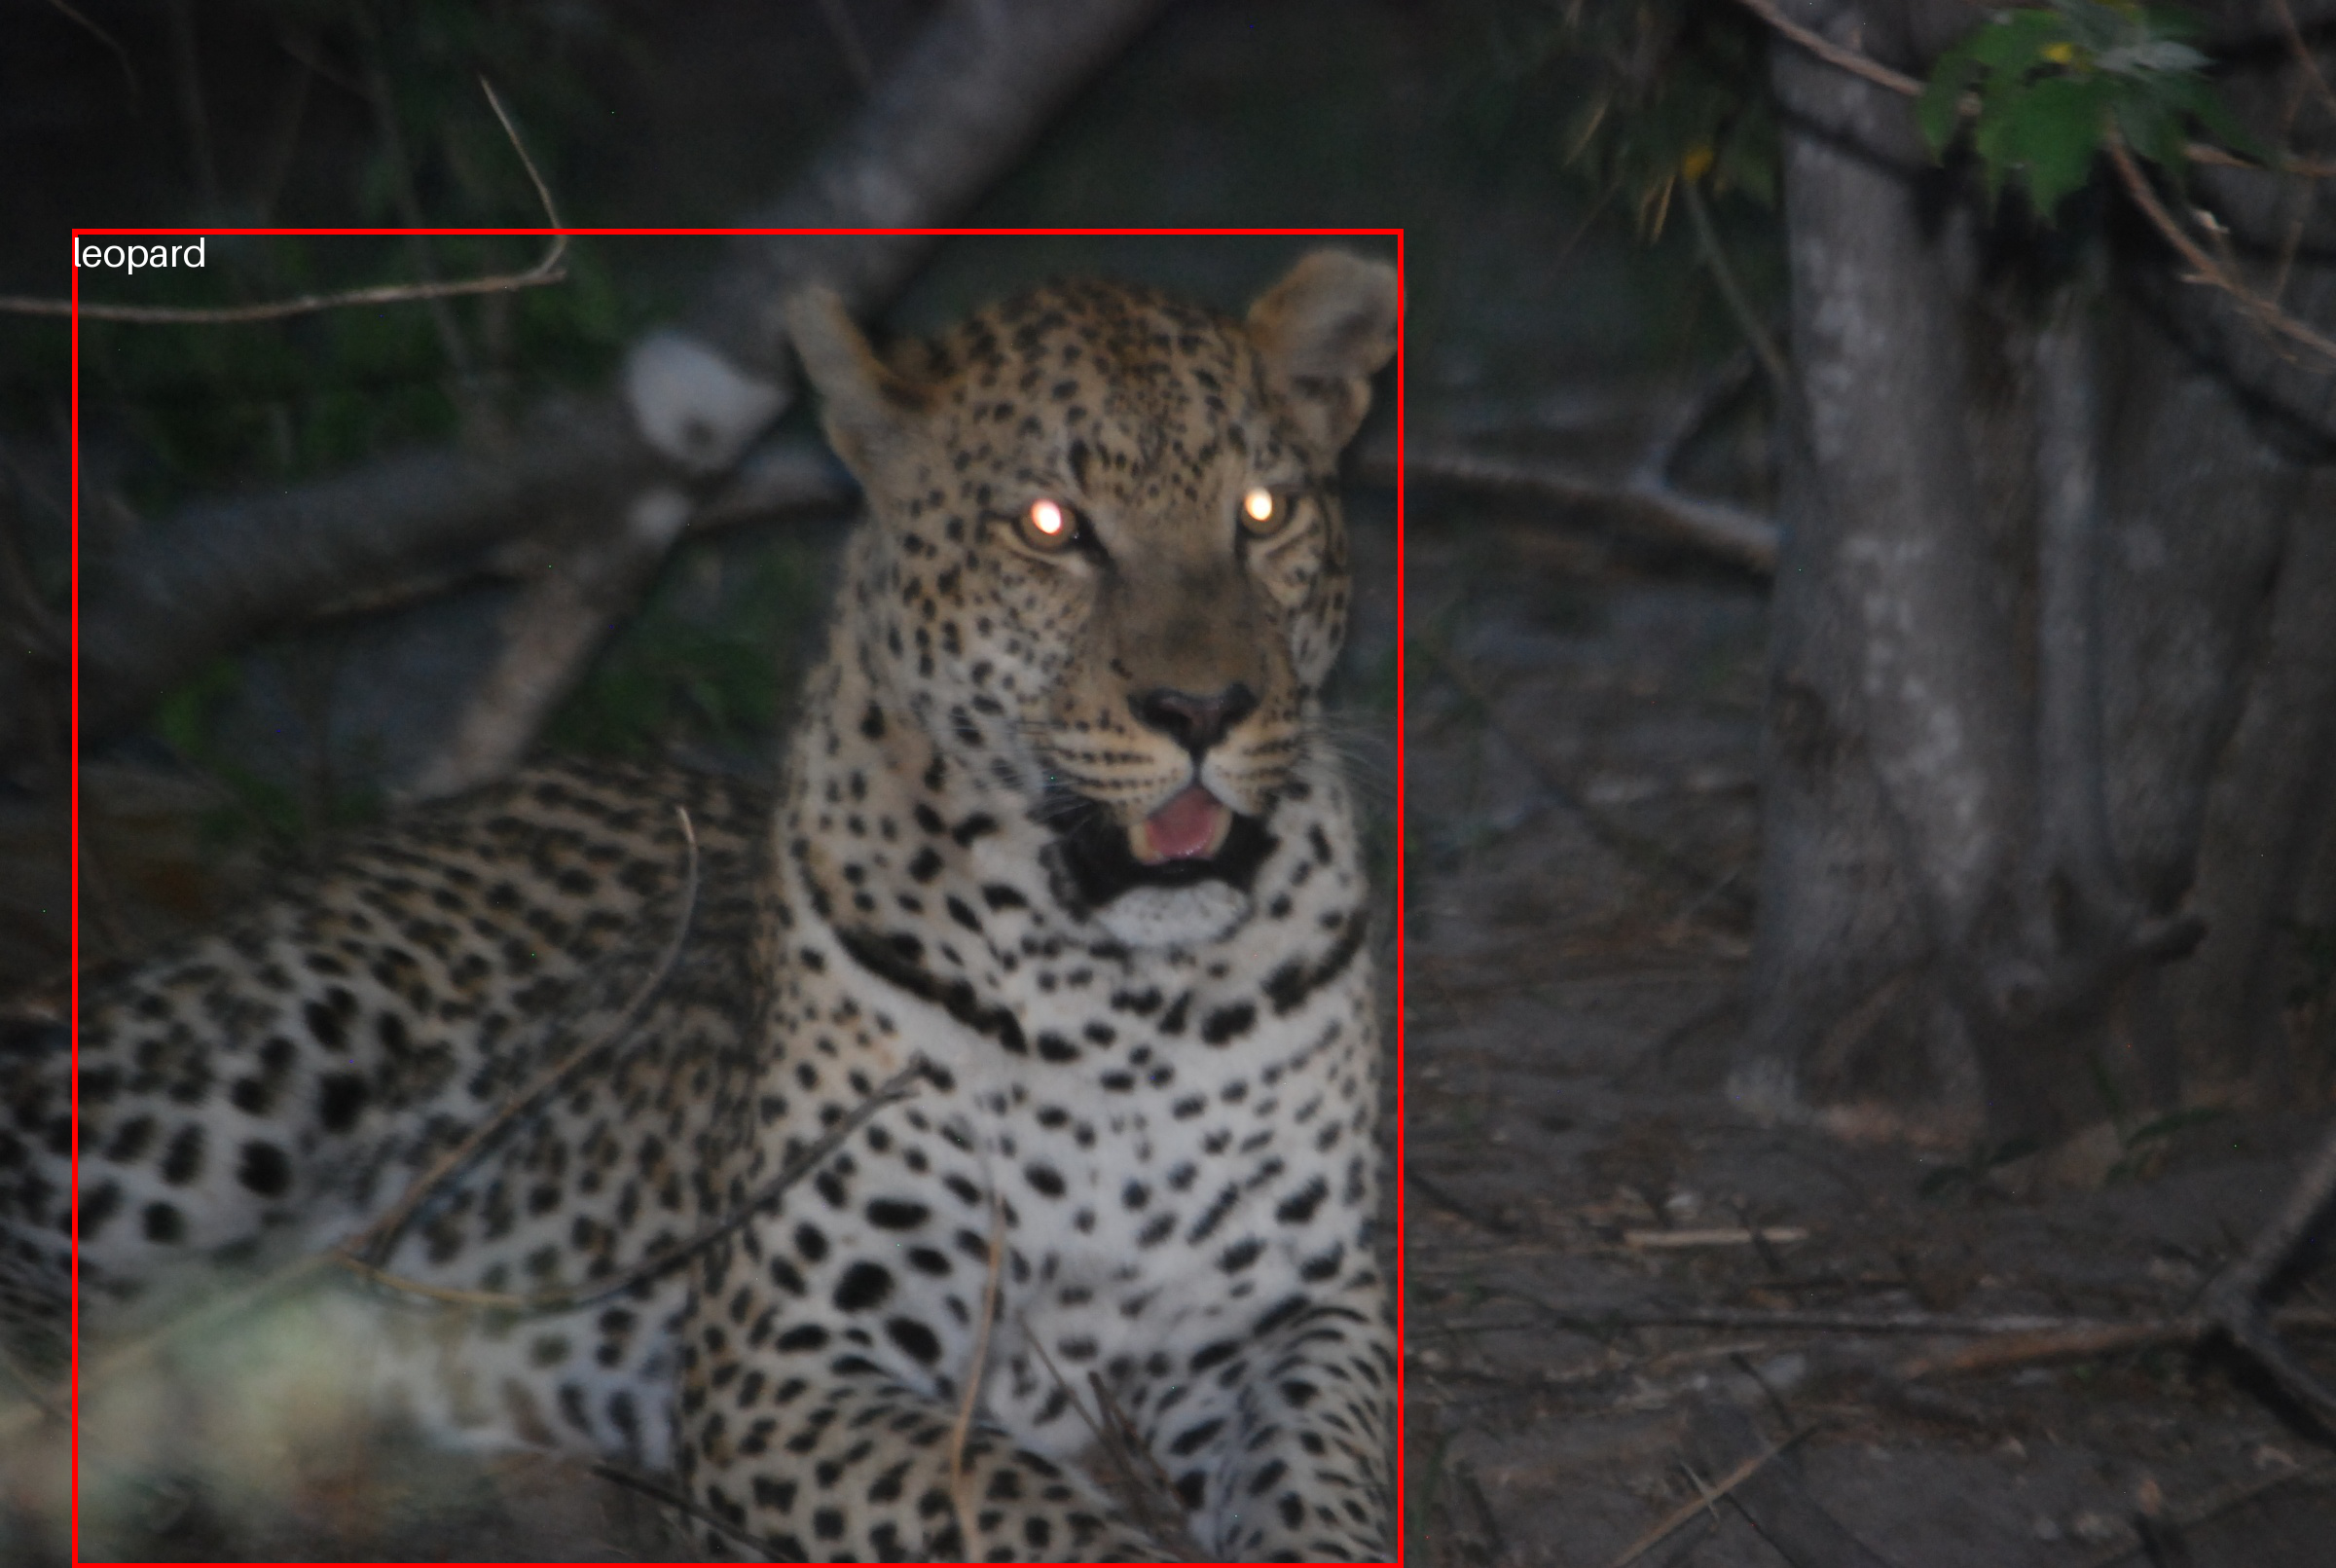

In [9]:
draw_image_from_idx(dataset=wildlife_train_ds, idx=10)

height -> 1800 | width -> 2400
x1 -> 306 | y1 -> 476 | x2 -> 2133 | y2 -> 1428
height -> 1600 | width -> 2400
x1 -> 470 | y1 -> 668 | x2 -> 1324 | y2 -> 1590
height -> 1600 | width -> 2400
x1 -> 1274 | y1 -> 927 | x2 -> 1846 | y2 -> 1196
height -> 1600 | width -> 2400
x1 -> 1025 | y1 -> 611 | x2 -> 1621 | y2 -> 970
height -> 1600 | width -> 2400
x1 -> 1048 | y1 -> 574 | x2 -> 1646 | y2 -> 928
height -> 1600 | width -> 2400
x1 -> 844 | y1 -> 682 | x2 -> 1407 | y2 -> 1252
height -> 1600 | width -> 2400
x1 -> 854 | y1 -> 644 | x2 -> 1435 | y2 -> 1100
height -> 1600 | width -> 2400
x1 -> 1014 | y1 -> 897 | x2 -> 1598 | y2 -> 1422
height -> 1600 | width -> 2400
x1 -> 719 | y1 -> 581 | x2 -> 1308 | y2 -> 1008


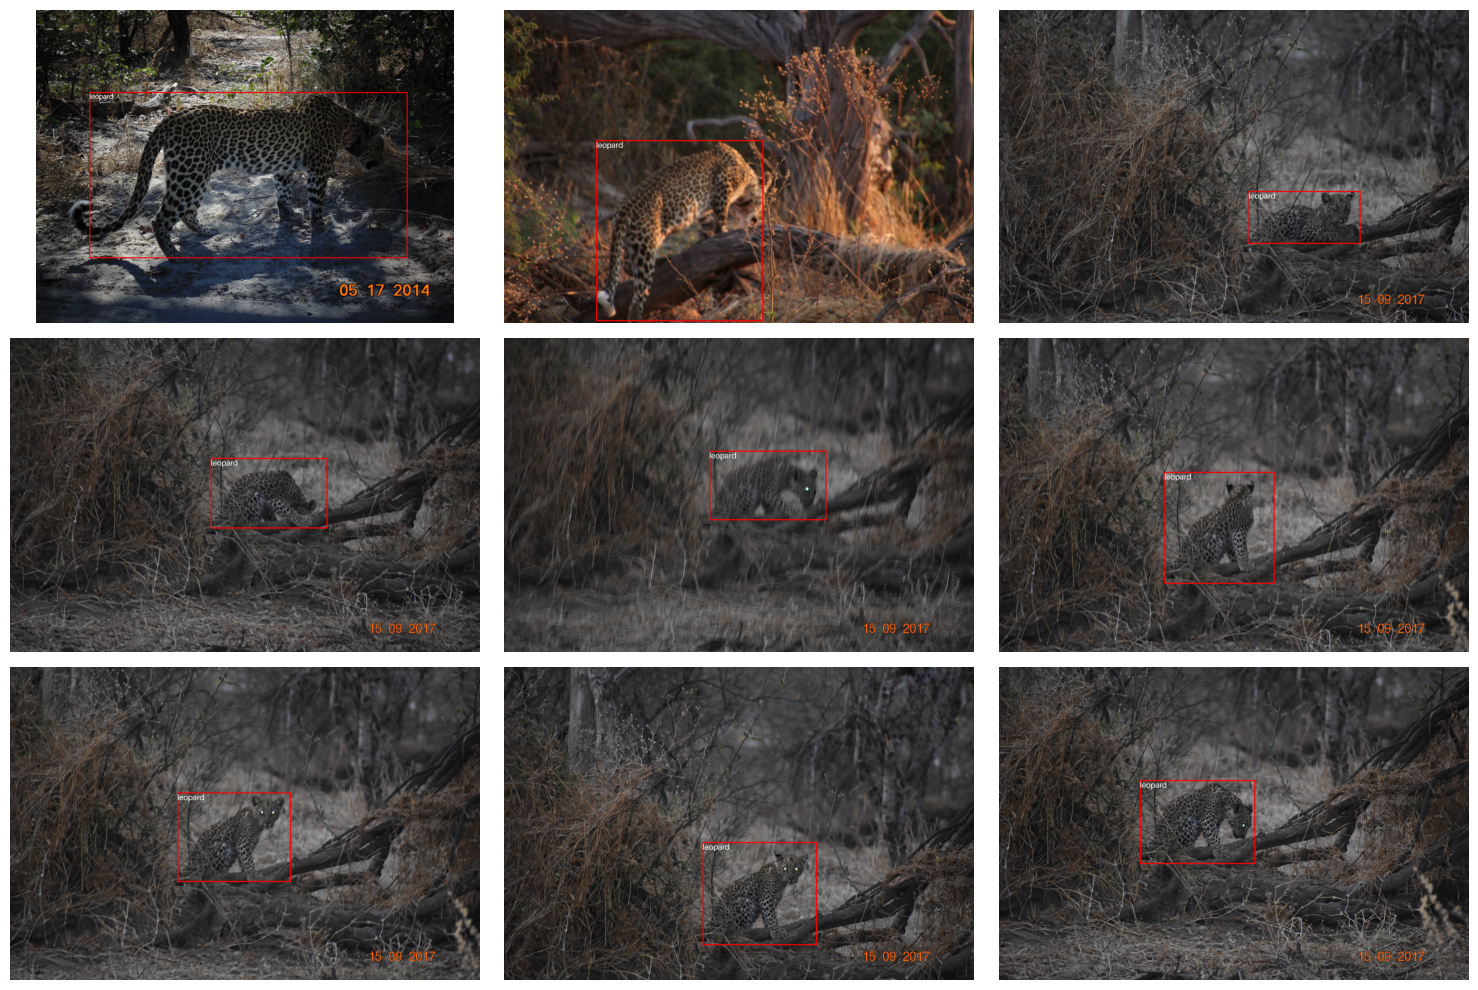

In [10]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images

plot_images(wildlife_train_ds, range(9))

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [12]:
def normalize_bboxes(bboxes, img_width, img_height):
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        # Normalize to [0, 1]
        normalized_bboxes.append([
            x_min / img_width,
            y_min / img_height,
            x_max / img_width,
            y_max / img_height,
        ])
    return normalized_bboxes

# transforming a batch


def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        #! category needs to be list, hence I put the extra brackets around it
        out = transform1(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [13]:
wildlife_train_ds_transformed = wildlife_train_ds.with_transform(transform_aug_ann)

In [14]:
wildlife_train_ds_transformed
del wildlife_train_ds

In [15]:
label2id = {"leopard" : 0, "hyena": 1}
id2label = {v:k for k, v in label2id.items()}

In [16]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [17]:
# hf_path = "SeaSponge/glow-detr-resnet-50"
# model = AutoModelForObjectDetection.from_pretrained(
#             hf_path,
#             id2label=id2label,
#             label2id=label2id,
#             ignore_mismatched_sizes=True)

# image_processor = AutoImageProcessor.from_pretrained(hf_path)

In [18]:
# Define the training arguments

checkpoint = "SenseTime/deformable-detr"
# model = GlowDeTR(
#     checkpoint,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatch_sz=True)

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

model = AutoModelForObjectDetection.from_pretrained(
            checkpoint,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True)

training_args = TrainingArguments(
    output_dir="glow-deformable-detr",
    per_device_train_batch_size=2,
    max_steps=3000,
    fp16=True,
    save_steps=10,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    lr_scheduler_type="cosine_with_restarts",  # Cosine scheduler with restarts
    # warmup_steps=300,  # Optional: Gradual increase in LR for first 300 steps
)


# Define the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=wildlife_train_ds_transformed,
    eval_dataset=None, #! unfortunately no test dataset yet
    tokenizer=image_processor,
)

trainer.train()
# saved_path = Path.cwd() / "results"
# trainer.save_model(saved_path)

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

  0%|          | 0/3000 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
